### Analysis high-frequency tidal gauge data (RWS waterwebservice) and comparison with monthly metric averages (PSMSL website)

Online notebook which compares two sets of tidal gauge data. This notebook uses the data obtained in the notebook 'retrieve timeseries from webservice RWS.ipynb' and 'retrieve timeseries from webservice PSMSL.ipynb'.

The obtained PSMSL is the monthly metric data. This dataset is provided by RWS to PSMSL. 
RWS also has a webservice from where gauge station data can be requested, this are high-frequency tidal gauge data. In this notebook to objective is to compare these datasets, where we hope to find minimal differences, as the tidal gauge data is measured by the same sensors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# these come with python
import io
import zipfile
import functools
import datetime

# for downloading
import nbformat
import requests
%matplotlib inline
%load_ext pycodestyle_magic

In [2]:
def execute_notebook(nbfile):
    with io.open(nbfile, encoding="utf8") as f:
        nb = nbformat.read(f, as_version=4)

    ip = get_ipython()

    for cell in tqdm(nb.cells):
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.source)

#### retrieve timeseries from webservice RWS

In the notebook 'retrieve timeseries from webservice RWS' the file stationData.h5 is created. The file contains high-frequency data of sea water levels along the Dutch coast. The data are subdivided into years. Here we access and read the file. 

In [3]:
hdf_file = Path('stationData.h5')
if not hdf_file.is_file():
    print('create stationData.h5 first, uncomment line below and re-run cell (execution notebook takes approx. 2 hours)')
    # execute_notebook('retrieve timeseries from webservice RWS.ipynb')
else:
    print('file stationData.h5 is already created, please continue')

file stationData.h5 is already created, please continue


In [4]:
if hdf_file.is_file():
    hdf = pd.HDFStore(str(hdf_file))  # depends on PyTables
    keys = hdf.keys()
    print('established connection to stationData.h5')
else:
    print('file stationData.h5 is not created, did you run previous code block')

established connection to stationData.h5


#### retrieve timeseries from webservice PSMSL

In the notebook 'retrieve timeseries from webservice PSMSL' the dataframe `df_psmsl` is created. This file contains monthly metric waterlevel data of sea water levels along the Dutch coast and is collected on-the-fly from PSMSL website. The converted DataFrame is in cm+NAP.

In [5]:
execute_notebook('retrieve timeseries from webservice PSMSL.ipynb')
# resulted DataFrame available as: df_psmsl

#### explorative analysis for Vlissingen

We start with an explorative analysis of the differences for the station of Vlissingen, but are mostly interested in the two metrics 'absolute mean difference (cm)' and 'absolute max difference (cm)' between the two datasets for all selected stations. This two metrics provide information how the two datasets are different from each other. Where the 'absolute mean difference' provides information on the average difference in cm and the 'absolute max difference (cm)' gives information on the peak difference on a given moment

In [6]:
columns = ['VLISSGN']
index_year = pd.date_range('1890', '2018', freq='A')
index_month = pd.date_range('1890', '2018', freq='M')
df_year = pd.DataFrame(index=index_year, columns=columns, dtype=float)
df_month = pd.DataFrame(index=index_month, columns=columns, dtype=float)

We create a function that can convert the HDFStore into multiple DataFrames that can be easily accessed later on. The dataframes created are all values combined, resampled to month and resampled to year

In [7]:
def convert_raw_df(hdf, columns, index_year, index_month, df_year, df_month):
    df_raw = pd.DataFrame()
    for station in columns:
        for year in tqdm(index_year):
            key = '/'+station+'/year'+str(year.year)
            if key in keys:
                if hdf[key].isnull().sum()[0] == hdf[key].size:
                    print('key {0} contains only 0 values')
                df_raw = df_raw.append(hdf[key])
                annual_mean = hdf[key].astype(float).mean()[0]
                monthly_mean = hdf[key].resample('M').mean()
                df_year.set_value(str(year), station, annual_mean)
                df_month.loc[monthly_mean.index,
                             station] = monthly_mean.as_matrix().flatten()
    return(df_raw, df_year, df_month)

In [8]:
# data is stored hdfstore as separate table for each year for each station
# merge all years for single station
columns = ['VLISSGN']
df_raw, df_year, df_month = convert_raw_df(hdf, columns, index_year,
                                           index_month, df_year, df_month)

First draw a histogram to get a bit insight in the distribution 

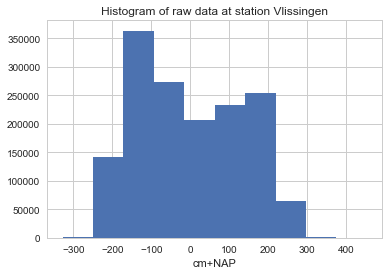

In [9]:
# histogram for the raw values to get insight in the distribution 
# over the period requested
xmin = datetime.datetime(1890,1,1)
xmax = datetime.datetime(2009,12,31)

df_raw.columns = ['Histogram of raw data at station Vlissingen']
ax = df_raw[(df_raw.index>xmin) & (df_raw.index<xmax)].hist()
ax.flatten()[0].set_xlabel("cm+NAP")
plt.show()

The data parsed from the RWS waterwebservice for Vlissingen between 1890 and 2009 seems legitimate. Lower end tide measurements reach -3m+NAP and high end time measurements reach 4m+NAP and there is a peak of measurements near -1.5m+NAP.

As we want to compare the RWS waterwebservice with the PSMSL montly metric values we first calculate the average monthly values from the RWS raw tidal gauge measurements

In [10]:
# since working with df_month introduces spikes at the annual change,
# we resample to monthly mean values using the raw dataframe.
df_raw.columns = columns
df_raw_M = df_raw.resample('M').mean()

In [11]:
df_raw_M.head()

,VLISSGN
time,
1900-01-31,-21.852151
1900-02-28,-24.608631
1900-03-31,-32.526882
1900-04-30,-32.601389
1900-05-31,-27.606183


Create a function to easily select a subset of the RWS dataframe containing monthly values, making sure the datetime index aligns with the PSMSL data (decimal year, with day set on 15 for monthly values)

In [12]:
def get_sel_seriesRWS(df_raw_M, xmin, xmax):
    raw_dates = []
    for raw_date in df_raw_M.loc[xmin:xmax].index:
        rw_date = pd.Timestamp(raw_date.year, raw_date.month, 15)
        raw_dates.append(rw_date)
    series_raw_dates = pd.Series(raw_dates)

    new_series_RWS = pd.Series(data=df_raw_M.loc[xmin:xmax].values.flatten(),
                               index=series_raw_dates.values)
    return new_series_RWS

Compare the monthly metric data from PSMSL and the monthly resmapled data from raw observations through the RWS webservice

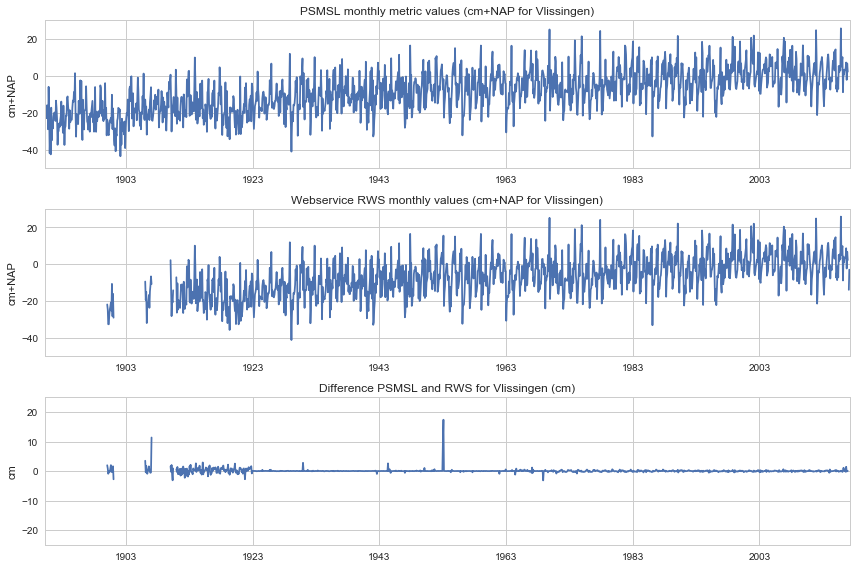

In [13]:
# range of period without major spikes
xmin = datetime.datetime(1890, 4, 1)
xmax = datetime.datetime(2017, 4, 1)
series_raw_M = get_sel_seriesRWS(df_raw_M, xmin, xmax)
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(df_psmsl.index, df_psmsl['VLISSINGEN_WATHTE_cmNAP'])
plt.ylabel('cm+NAP')
plt.ylim(-50, 30)
plt.xlim(xmin, xmax)
plt.title('PSMSL monthly metric values (cm+NAP for Vlissingen)')

plt.subplot(312)
plt.plot(series_raw_M.index, df_raw_M['VLISSGN'].loc[xmin:xmax])
plt.ylim(-50, 30)
plt.xlim(xmin, xmax)
plt.ylabel('cm+NAP')
plt.title('Webservice RWS monthly values (cm+NAP for Vlissingen)')

plt.subplot(313)
dif_series = (series_raw_M -
              df_psmsl['VLISSINGEN_WATHTE_cmNAP'].loc[xmin:xmax])
plt.plot(dif_series.index, dif_series.values)
plt.ylim(-25, 25)
plt.xlim(xmin, xmax)
plt.ylabel('cm')
plt.title('Difference PSMSL and RWS for Vlissingen (cm)')

plt.tight_layout()

Looking to the top chart it shows that the dataset from PSMSL contains no gaps. The data collected from the RWS waterwebservice has a number of gaps in the end of the 19th and beginning of 20th century (center-chart). The bottom chart shows the absolute difference between the two datasets and the discrepancies at the beginning (in terms of time) of the timeseries are higher (both the minima and maxima), after 1923 the spread of the absolute difference is reaching zero except for a few occassions, which indicate on a certain outlier removal post process.

For example, the absolute difference diagram shows a single big spike around 1953, at Vlissingen. This might be the North Sea flood of 1953.

Another detailed look at the North Sea Flood of 1953:

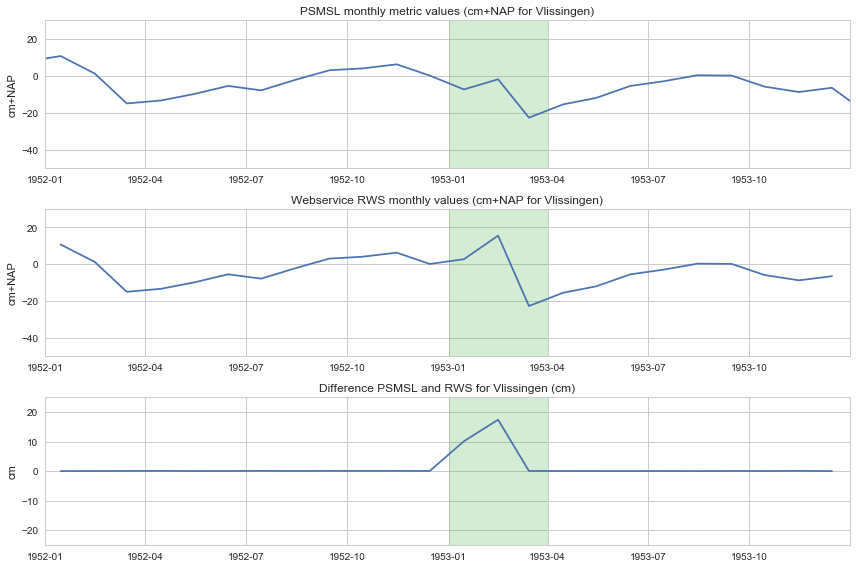

In [14]:
xmin = datetime.datetime(1952, 1, 1)
xmax = datetime.datetime(1953, 12, 31)
series_raw_M = get_sel_seriesRWS(df_raw_M, xmin, xmax)
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(df_psmsl.index, df_psmsl['VLISSINGEN_WATHTE_cmNAP'])
plt.axvspan(datetime.datetime(1953, 1, 1), datetime.datetime(1953, 4, 1),
            facecolor='#2ca02c', alpha=0.2)
plt.ylabel('cm+NAP')
plt.ylim(-50, 30)
plt.xlim(xmin, xmax)
plt.title('PSMSL monthly metric values (cm+NAP for Vlissingen)')

plt.subplot(312)
plt.plot(series_raw_M.index, series_raw_M.values)
plt.axvspan(datetime.datetime(1953, 1, 1), datetime.datetime(1953, 4, 1),
            facecolor='#2ca02c', alpha=0.2)
plt.ylim(-50, 30)
plt.xlim(xmin, xmax)
plt.ylabel('cm+NAP')
plt.title('Webservice RWS monthly values (cm+NAP for Vlissingen)')

plt.subplot(313)
dif_series = (series_raw_M -
              df_psmsl['VLISSINGEN_WATHTE_cmNAP'].loc[xmin:xmax])
plt.plot(dif_series.index, dif_series.values)
plt.axvspan(datetime.datetime(1953, 1, 1), datetime.datetime(1953, 4, 1),
            facecolor='#2ca02c', alpha=0.2)
plt.ylim(-25, 25)
plt.xlim(xmin, xmax)
plt.ylabel('cm')
plt.title('Difference PSMSL and RWS for Vlissingen (cm)')
plt.tight_layout()

It is somehow surprising that this spike in the North Sea Flood of 1953 is not present in the PSMSL Monthy metric data. The data comprising the Northsea flood is not a single peak event, but covers two months. The period can be seen as an outlier and therefor be removed in the process data cleansing, but it is a known occurrence which cannot be attributed to a background noise (for which data cleansing is appropriate). For now it is not clear why it should not be presented in the PSMSL dataset

#### comparision absolute differences all selected stations

Next we compute the differences between PSMSL and RWS for all selected stations, including the metrics 'absolute mean difference (cm)' and 'absolute max difference (cm)'.

In [15]:
# first create a helper function to extraxt the mean, max and
# series containing the absolute difference given two stations 
# and a period
def getdif_maxmean(col_RWS, col_PSMSL, xmin, xmax,
                   hdf, columns, index_year, index_month,
                   df_year, df_month):
    columns = [col_RWS]
    df_raw, df_year, df_month = convert_raw_df(hdf, columns,
                                               index_year, index_month,
                                               df_year, df_month)
    df_raw_M = df_raw.resample('M').mean()

    series_raw_M = get_sel_seriesRWS(df_raw_M, xmin, xmax)
    dif_series = (series_raw_M - df_psmsl[col_PSMSL].loc[xmin:xmax])
    return abs(dif_series).mean(), abs(dif_series).max(), dif_series

Prepare a new dataframe with the absolute differences for all stations as series and a separate dataframe with the metrics

In [16]:
df_diff_sel_stations = pd.DataFrame()

xmin = datetime.datetime(1890, 1, 1)
xmax = datetime.datetime(2017, 12, 31)

abs_dif_mean_list = []
abs_dif_max_list = []
name_list = []

cols_RWS = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD',
            'IJMDBTHVN', 'VLISSGN']
cols_PSMSL = ['DELFZIJL_WATHTE_cmNAP', 'DEN HELDER_WATHTE_cmNAP',
              'HARLINGEN_WATHTE_cmNAP', 'HOEK VAN HOLLAND_WATHTE_cmNAP',
              'IJMUIDEN_WATHTE_cmNAP', 'VLISSINGEN_WATHTE_cmNAP']

for idx, col_RWS in enumerate(tqdm(cols_RWS)):
    col_PSMSL = cols_PSMSL[idx]
    print('station PSMSL {0} - station RWS {1}'.format(col_PSMSL, col_RWS))
    # get the data from both datasets
    abs_dif_mean, abs_dif_max, dif_series = getdif_maxmean(col_RWS, col_PSMSL,
                                                           xmin, xmax, hdf,
                                                           columns, index_year,
                                                           index_month, df_year,
                                                           df_month)
    # append to new lists and overview dataframe
    abs_dif_mean_list.append(abs_dif_mean)
    abs_dif_max_list.append(abs_dif_max)
    name_list.append(col_RWS)
    dif_series.name = col_RWS
    df_diff_sel_stations = pd.concat((df_diff_sel_stations, dif_series),
                                     axis=1)

station_difs = pd.DataFrame([abs_dif_mean_list, abs_dif_max_list],
                            columns=name_list,
                            index=['absolute mean difference (cm)',
                                   'absolute max difference (cm)'])

station PSMSL DELFZIJL_WATHTE_cmNAP - station RWS DELFZL
station PSMSL DEN HELDER_WATHTE_cmNAP - station RWS DENHDR
station PSMSL HARLINGEN_WATHTE_cmNAP - station RWS HARLGN
station PSMSL HOEK VAN HOLLAND_WATHTE_cmNAP - station RWS HOEKVHLD
station PSMSL IJMUIDEN_WATHTE_cmNAP - station RWS IJMDBTHVN
station PSMSL VLISSINGEN_WATHTE_cmNAP - station RWS VLISSGN



Let's plot an overview of the timeseries containing the absolute differences of all selected stations

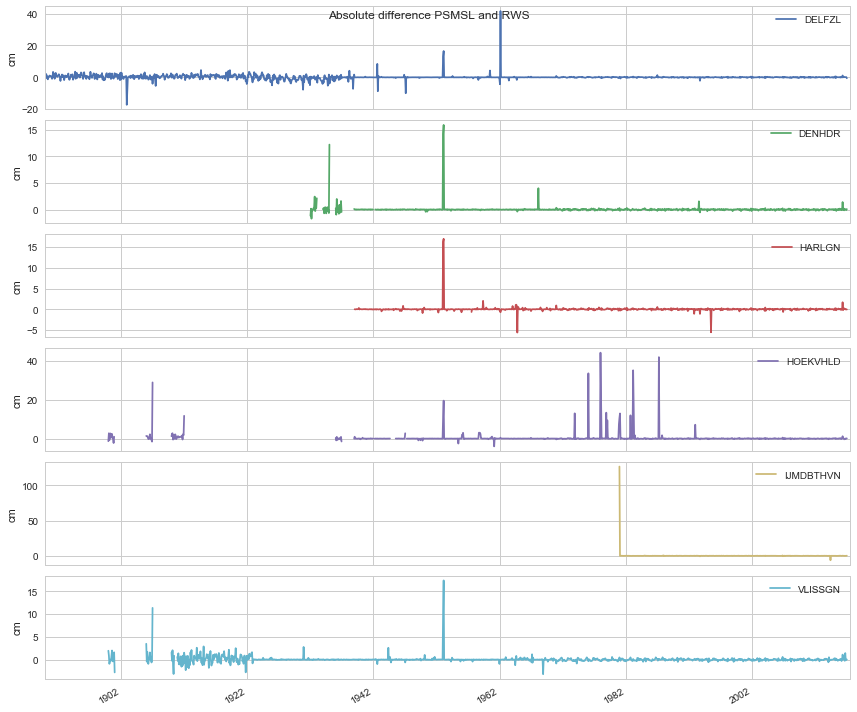

In [17]:
axes = df_diff_sel_stations.plot(subplots=True, legend=True,
                                 figsize=(12, 10), sharex=True,
                                 title='Absolute difference PSMSL and RWS')
for ax in axes:
    ax.set(ylabel='cm')
plt.tight_layout()

The graphs of the differences show that the two data sources produce different time series for all stations. Moreover, the two data sources contain at least one large spike for each station. 

In [18]:
print(station_difs.mean(axis=1))
station_difs.head()

absolute mean difference (cm)     0.342360
absolute max difference (cm)     43.826375
dtype: float64


,DELFZL,DENHDR,HARLGN,HOEKVHLD,IJMDBTHVN,VLISSGN
absolute mean difference (cm),0.606863,0.130802,0.143925,0.532790,0.394272,0.245511
absolute max difference (cm),41.565789,15.859767,17.009375,44.345186,126.800000,17.378134


This differences comes back in the metrics of the absolute mean difference (cm) and absolute max difference (cm) overall and for each location. Looking to the metrics for each station it can is observed that Den Helder, Harlingen and Vlissingen has a absolute mean difference below the overall average mean difference, with Den Helder as the location with the fewest differences.

Regarding the absolute max differences for each station there is a strong outlier for location IJmuiden Buitenhaven, where the initial values produced an absolute max difference of 126.8 centimeter. For stations Den Helder, Harlingen, Hoek van Holland and VLissingen the absolute max difference is between 15.9 and 44.3 centimeter, where these spikes are all observed during the North Sea Flood of 1953.

#### Conclusion
It has not been possible to reproduce exactly the annual average sea levels from the online available RWS data. The annual averages have been calculated in the most straightforward way from the high-frequency RWS data (10-minute time series since 1987). These values have been compared with the annual averages in the PSMSL database, which have been uploaded by RWS. The differences are not caused by the relevelling of NAP in 2005. Correspondence with Mr. Koos Doekes has learned that the differences since 1987 are due to RWS using the hourly (instead of 10-minute) values to calculate the annual average sea levels that were sent to PSMSL.

#### Recommendation. 
It is important to reproduce the annual average sea-level at the stations along the Dutch coast. Therefore, RWS should formally write down the procedure to calculate the annual averages